In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import sys
from datetime import datetime
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import cvxopt
import random
from scipy.optimize import root_scalar

aeq_dir = "/mnt/c/Users/jan.zill/code/aequilibrae"
sys.path.append(aeq_dir)
from aequilibrae.paths.path_based.cythoncodetest import OpenBenchmark
from aequilibrae.paths.path_based import TrafficAssignmentCy

import utils

In [4]:
code_dir = "/mnt/c/Users/jan.zill/code"
tntp_dir = os.path.join(code_dir, "TransportationNetworks_aequilibrae")

In [5]:
%%time
scenario = "Anaheim" #"Berlin-Center" #
num_iters = 10
cvxopt.solvers.options['show_progress'] = False
#cvxopt.solvers.options['maxiters'] = 6 #
cvxopt.solvers.options['abstol'] =1e-11
cvxopt.solvers.options['reltol'] =1e-11
cvxopt.solvers.options['feastol'] =1e-11

print(f"{datetime.now()} - Running scenario {scenario}")

folder = os.path.join(tntp_dir, scenario)

if scenario == "Anaheim":
    link_file =  "Anaheim_net.tntp"
    trip_file =  "Anaheim_trips.tntp"
elif scenario == "Berlin-Center":
    link_file =  "berlin-center_net_clean.tntp" # DUPLICATE NODES REMOVED
    trip_file =  "berlin-center_trips.tntp"
else:
    raise ValueError(f"Unknown scenario {scenario}")


### Build data structures
bch = OpenBenchmark(folder, link_file, trip_file)
links, nodes, ods, destinations, origins = bch.build_datastructure()
num_links = len(links)
num_nodes = len(nodes)
num_centroids = len(origins)
print(f"{datetime.now()} - num nodes = {len(nodes)}, num links = {len(links)}")
bch.get_data_structure_with_by_directional_links()
### end build ds

### initialise Ass, add ds
t_assignment = TrafficAssignmentCy.TrafficAssignmentCy(links,num_links,num_nodes,num_centroids)
destinations_per_origin = {}
#t = 0
for (o,d) in ods:
    t_assignment.insert_od(o, d, ods[o,d])
    if o not in destinations_per_origin:
        destinations_per_origin[o] = 0
    destinations_per_origin[o] += 1

    
### Ini solution, iter 0
print(f"{datetime.now()} - performing initial solution")
t_assignment.perform_initial_solution()
costs = [t_assignment.get_objective_function()]
gaps = [1] #initial gap, fix to arbitrary value or better compute it


### Iterations
solutions_per_origin = {}
od_path_times = {}

for i in range(num_iters):
    print(f"  {datetime.now()} - starting iteration {i}")
    origins = destinations_per_origin.keys()
    for origin in origins:
        #t1 = time.time()
        t_assignment.compute_shortest_paths(origin)
        #t2 = time.time()
        #shortest_path_time += t2 - t1
    #print(f"  {datetime.now()} - dijsktra done")
    
    #for origin in origins:
        #t2 = time.time()
        t_paths = t_assignment.get_total_paths(origin)
        Q,q,A,b,G,h = t_assignment.get_problem_data(origin,destinations_per_origin[origin])
        Am = cvxopt.matrix(A.tolist(), (t_paths, destinations_per_origin[origin]),"d")
        bm = cvxopt.matrix(b.tolist(), (destinations_per_origin[origin],1),"d")
        Qm = cvxopt.matrix(Q.tolist(), (t_paths,t_paths),"d")
        qm = cvxopt.matrix(q.tolist(), (t_paths,1),"d")
        Gm = cvxopt.matrix(G.tolist(), (t_paths,t_paths),"d")
        hm = cvxopt.matrix(h.tolist(), (t_paths,1),"d")
        #t3 = time.time()
        solution = cvxopt.solvers.qp(Qm.trans(), qm, Gm.trans(), hm, Am.trans(), bm)["x"]
        #t4 = time.time()
        
        solutions_per_origin[origin] = solution
        
        #opt_setup_time += t3 - t2
        #opt_solv_time += t4 - t3
    #print(f"  {datetime.now()} - qp done")

    # so far nothing should have changed, right?
# the following needs to change though:
#     for origin in origins:
#         t4 = time.time()
#         t_assignment.update_path_flows(origin, solutions_per_origin[origin])
#         t5 = time.time()
#         update_time += t5 - t4
#     print(f"  {datetime.now()} - update done")

    #for origin in origins:
        #t4 = time.time()
        # TODO: change name, this is misleading
        # compute the new solution by assigning the path flows, but do not update the current solution yet
        t_assignment.update_path_flows_without_link_flows(origin, solution) #solutions_per_origin[origin])
        #t5 = time.time()
        #update_time += t5 - t4
    print(f"  {datetime.now()} - update done")

    # not parallel:
    # Find stepsize, for now set it to 0.4 or 0.35
    try:
        min_res = root_scalar(lambda x: t_assignment.objective_derivative_stepsize(x), bracket=[0, 1])
#         left_ = t_assignment.objective_derivative_stepsize(0)
#         right_ = t_assignment.objective_derivative_stepsize(1)
#         print(f"     {left_:.0f}, {right_:.0f}")
        stepsize = min_res.root
    except ValueError:
        left_ = t_assignment.objective_derivative_stepsize(0)
        right_ = t_assignment.objective_derivative_stepsize(1)
        print(f"     error finding stepsize: {left_:.0f}, {right_:.0f}")
        # need to decide what to do here
        if left_ < right_:
            stepsize = 0.01
        else:
            stepsize = 0.99
    print(f"  {datetime.now()} - Stepsize finding done: {stepsize}")

    
    # update solution:
    # new solution of link flows = sum_{r in origin} (1-stepsize) old_solution_r + stepsize new_solution_r
    for origin in origins:
        t_assignment.update_link_flows_stepsize(origin, stepsize)
    print(f"  {datetime.now()} - Taking step done")

    t_assignment.update_all_link_derivatives()
    print(f"  {datetime.now()} - Updated derivatives")
    

    for origin in origins:
        # update path flows: new_path_flows = (1-stepsize) * old_path_flow + stepsize * new_path_flow
        t_assignment.update_path_flows_stepsize(origin, stepsize, solutions_per_origin[origin]) # new try
        # 
    print(f"  {datetime.now()} - blended path flows")


    this_cost = t_assignment.get_objective_function()
    costs.append(this_cost)

    od_path_times[i] = {}
    num = 0
    dem = 0
    for (origin,destination) in ods:
        p_times, p_flows = t_assignment.get_path_times(origin, destination)
        # print origin, destination, p_times
        od_path_times[i][origin,destination] = (p_times,p_flows)           
        # gap
        num += sum(p_flows)*min(p_times)
        for ind in range(len(p_times)):
            dem += p_times[ind]*p_flows[ind]
    gap = 1-num/dem
    gaps.append(gap)

    print(f"  {datetime.now()} - computed path times and flows, computed gap: {gap}, computed objective: {this_cost}")

print(f"{datetime.now()} - Done")
flows = t_assignment.get_link_flows()
t_ = []
for i in range(len(flows)):
    t_.append([links[i].node_id_from+1, links[i].node_id_to+1, flows[i], links[i].get_time(flows[i])])
res_ = pd.DataFrame(data=t_, columns=['a_node', 'b_node', 'flow', 'time'])
print(f"{datetime.now()} - Flows extracted")

2020-12-06 17:16:17.986556 - Running scenario Anaheim
2020-12-06 17:16:17.995026 - num nodes = 416, num links = 914
2020-12-06 17:16:18.005471 - performing initial solution
  2020-12-06 17:16:18.032152 - starting iteration 0
  2020-12-06 17:16:18.395395 - update done
     -220674, 46764
  2020-12-06 17:16:18.404646 - Stepsize finding done: 0.6041183570531465
  2020-12-06 17:16:18.404753 - Taking step done
  2020-12-06 17:16:18.405075 - Updated derivatives
  2020-12-06 17:16:18.405688 - blended path flows
  2020-12-06 17:16:18.417457 - computed path times and flows, computed gap: 0.01259564977596661, computed objective: 1214708.375
  2020-12-06 17:16:18.417727 - starting iteration 1
  2020-12-06 17:16:18.818879 - update done
     -18621, 38202
  2020-12-06 17:16:18.825247 - Stepsize finding done: 0.42639585717232686
  2020-12-06 17:16:18.825705 - Taking step done
  2020-12-06 17:16:18.826367 - Updated derivatives
  2020-12-06 17:16:18.827111 - blended path flows
  2020-12-06 17:16:18.84

In [38]:
%%time
compare_flows = True
if compare_flows:
    bfw_res_ = utils.get_gradient_descent_solution(tntp_dir, scenario, link_file, block_centroids=False, rgap=5*1e-5)

CPU times: user 8.34 s, sys: 281 ms, total: 8.62 s
Wall time: 4.23 s


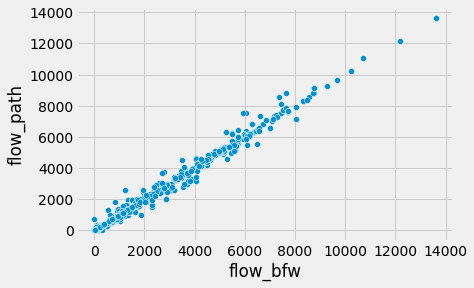

max diff in flow = 1581.170
max rel diff in flow = 281716956.746%


,link_id,a_node,b_node,ff_time,capacity,direction,flow_bfw,flow_path,abs_change,rel_change
423,423,269,25,0.149068,12600,1,5949.637996,7530.808105,1581.170109,0.265759
31,31,25,268,0.149068,12600,1,6041.763444,7517.915039,1476.151595,0.244325
398,398,261,269,1.859848,5400,1,1213.546166,2613.723633,1400.177466,1.153790
131,131,83,261,0.500000,1800,1,1213.546166,2613.723633,1400.177466,1.153790
645,645,337,29,0.149068,12600,1,7646.594981,8823.936523,1177.341543,0.153969
39,39,29,308,0.149068,12600,1,7376.994952,8541.154297,1164.159345,0.157809
179,179,115,114,0.229038,7200,1,5240.774880,6300.020020,1059.245140,0.202116
178,178,114,113,0.316192,7200,1,5240.774880,6300.020020,1059.245140,0.202116
177,177,113,195,0.333333,7200,1,3490.868891,4492.695312,1001.826422,0.286985
492,492,294,115,0.500000,1800,1,832.368936,1834.194824,1001.825888,1.203584


CPU times: user 203 ms, sys: 46.9 ms, total: 250 ms
Wall time: 255 ms


In [7]:
%%time
compare_flows = True
if compare_flows:
    full_result = bfw_res_.rename(columns={'time': 'ff_time'}).merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer', suffixes=['_bfw', '_path'])
    sns.scatterplot(data=full_result, x='flow_bfw', y='flow_path');
    plt.show();
    full_result['abs_change'] = np.abs(full_result.flow_bfw - full_result.flow_path)
    full_result['rel_change'] = full_result['abs_change'] / full_result['flow_bfw']
    print(f"max diff in flow = {full_result['abs_change'].max():.3f}")
    print(f"max rel diff in flow = {full_result['rel_change'].abs().max():.3f}%")
    display(full_result.sort_values(by=['abs_change'], ascending=False).head(10))

In [ ]:
# Cannot compare, best solution blocks flows through centroids. Agrees with BFW, so let's go with comparison to that
# #if scenario == "Anaheim":
# best_ = pd.read_csv(os.path.join(tntp_dir, scenario, "Anaheim_flow.tntp"), skiprows=5, sep="\t")
# best_ = best_.drop(columns=['~ ', ": ", "; "])
# best_ = best_.rename(columns={"Tail ": "a_node", "Head ": "b_node", "Volume ": "flow_best"})
# full_result = best_.merge(res_.drop(columns=['time']), on=['a_node', 'b_node'], how='outer')
# sns.scatterplot(data=full_result, x='flow_best', y='flow');